<a href="https://colab.research.google.com/github/QUADRIABUBAKAR/ACCESS-Data-science-assignment/blob/main/Project_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [89]:
from google.colab import drive
drive.mount('/content/drive')
# load the dataset
df = pd.read_csv('/content/drive/MyDrive/insurance.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Basic Data inspection

In [90]:
print("Shape:", df.shape)

Shape: (1338, 7)


In [91]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [92]:
df.dtypes

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


In [93]:
cols = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
for c in cols:
  # Only display value counts for categorical or low-cardinality numerical columns for better readability
  if df[c].dtype == 'object' or df[c].nunique() < 20:
    print(f"\nValue counts for {c}:")
    display(df[c].value_counts())


Value counts for sex:


,count
sex,
male,676
female,662



Value counts for children:


,count
children,
0,574
1,324
2,240
3,157
4,25
5,18



Value counts for smoker:


,count
smoker,
no,1064
yes,274



Value counts for region:


,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


In [ ]:
display(df.describe().T) # Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801



Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


# Data Cleaning

In [ ]:
# Cell 3: Convert dtypes for categorical columns
cat_cols = ["sex", "smoker", "region"]
for c in cat_cols: df[c] = df[c].astype("category")

# children is numeric but small integer counts; keep as int
df["children"] = df["children"].astype(int)

# Verify
display(df.dtypes)

,0
age,int64
sex,category
bmi,float64
children,int64
smoker,category
region,category
charges,float64


In [ ]:
numeric = df.columns[df.dtypes != "object"]
cat = df.columns[df.dtypes == "object"]


# EDA

### Univariate Analysis

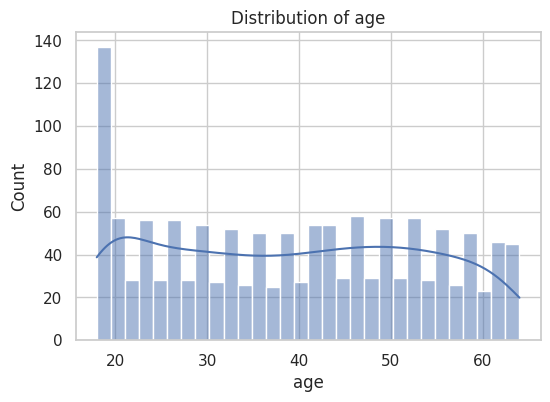

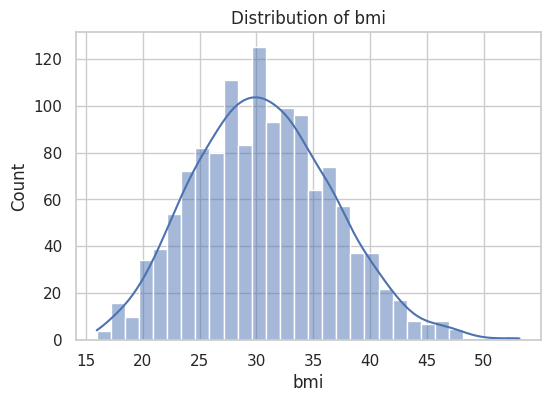

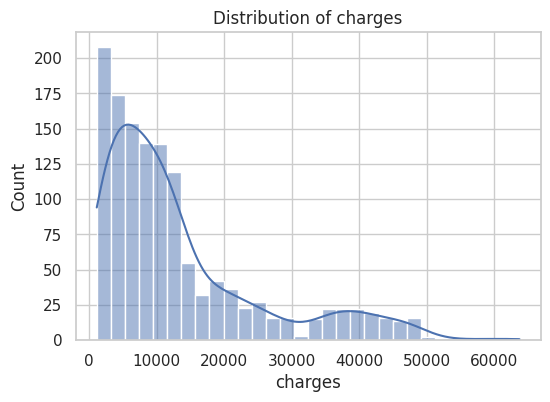

/tmp/ipython-input-2746521159.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="viridis")


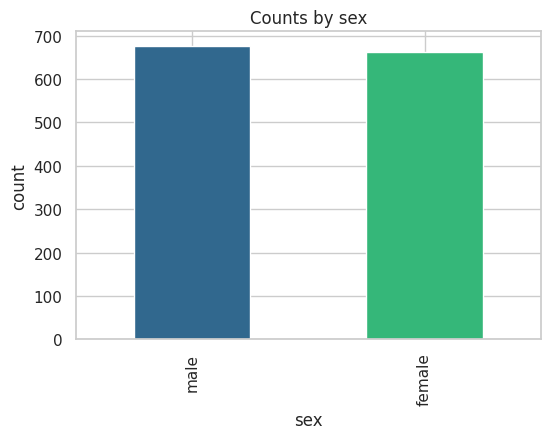

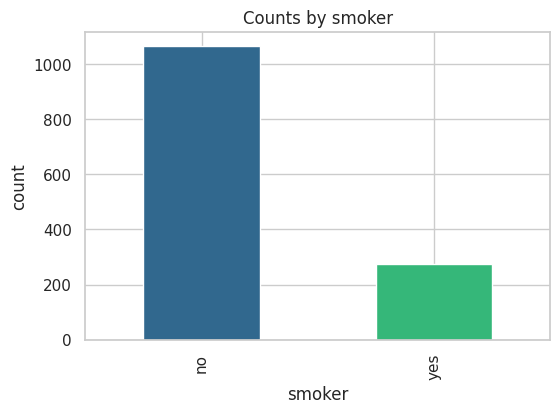

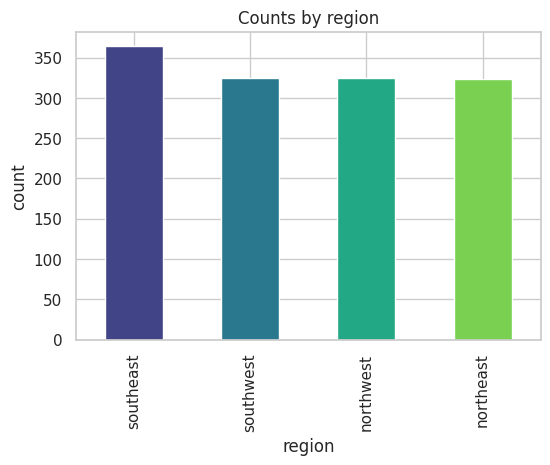

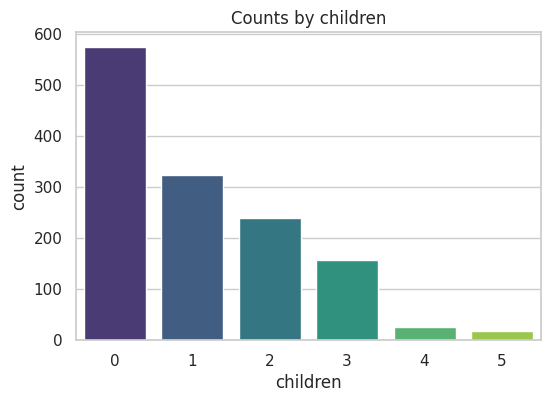

In [110]:
# Cell 6: Univariate numeric histograms

num_cols = ["age", "bmi", "charges"]
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()
    print("\n")

# Categorical bar plots
cat_cols_plot = ["sex", "smoker", "region", "children"]
for col in cat_cols_plot:
    plt.figure(figsize=(6,4))
    if col == "children":
        sns.countplot(x=col, data=df, palette="viridis")
    else:
        df[col].value_counts().plot(kind="bar", color=sns.color_palette("viridis", n_colors=df[col].nunique()))
        plt.ylabel("count")
    plt.title(f"Counts by {col}")
    print("\n")


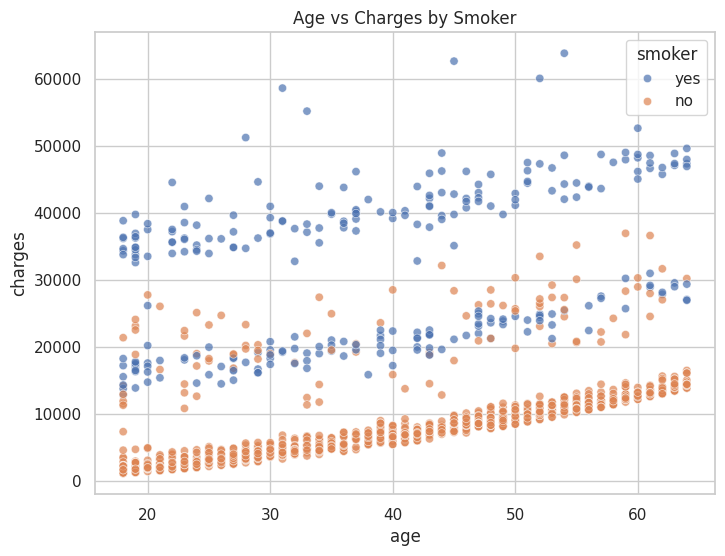

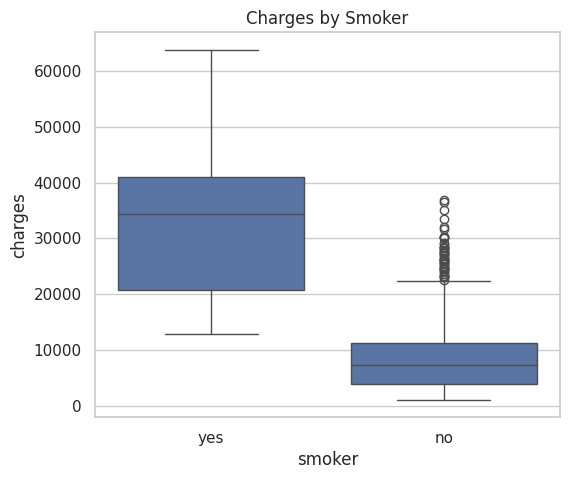

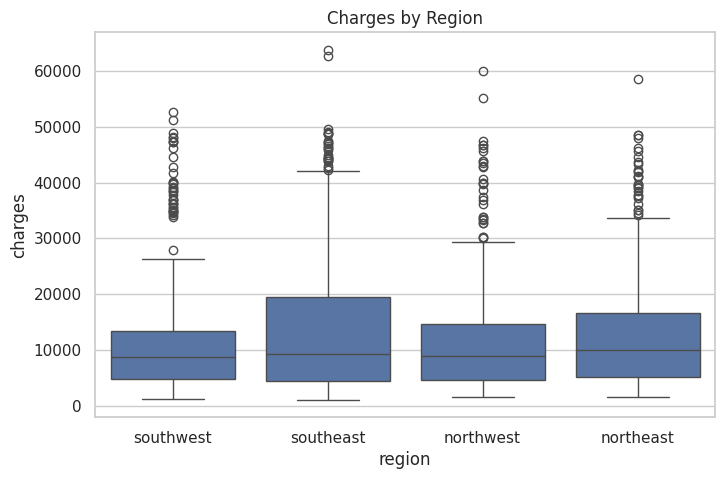

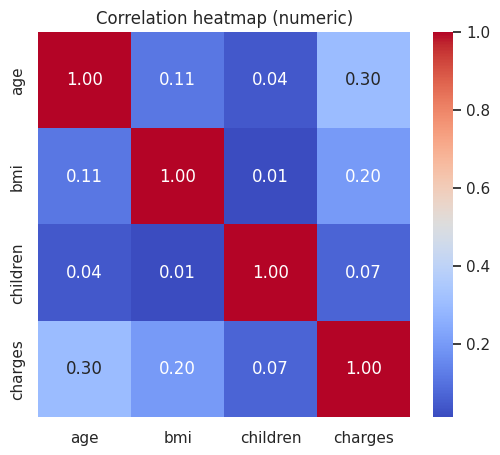

In [95]:
# Cell 7: Scatter age vs charges colored by smoker
plt.figure(figsize=(8,6))
sns.scatterplot(x="age", y="charges", hue="smoker", data=df, alpha=0.7)
plt.title("Age vs Charges by Smoker")
plt.savefig("fig_bivariate_age_charges_smoker.png", bbox_inches="tight", dpi=150)
plt.show()
print("\n")

# Boxplots: charges by smoker and by region
plt.figure(figsize=(6,5))
sns.boxplot(x="smoker", y="charges", data=df)
plt.title("Charges by Smoker")
plt.show()
print("\n")

plt.figure(figsize=(8,5))
sns.boxplot(x="region", y="charges", data=df)
plt.title("Charges by Region")
plt.show()
print("\n")

# Correlation heatmap for numeric features
plt.figure(figsize=(6,5))
num_df = df[["age","bmi","children","charges"]]
corr = num_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap (numeric)")
plt.show()
print("\n")


Outliers

In [ ]:
#IQR-based outliers for charges column
def find_iqr_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series < lower) | (series > upper)]

outliers_charges = find_iqr_outliers(df['charges'].dropna())
print("IQR-based outliers in charges (count):", outliers_charges.shape[0])
display(outliers_charges.tail())

IQR-based outliers in charges (count): 139


,charges
1300,62592.87309
1301,46718.16325
1303,37829.72420
1313,36397.57600
1323,43896.37630


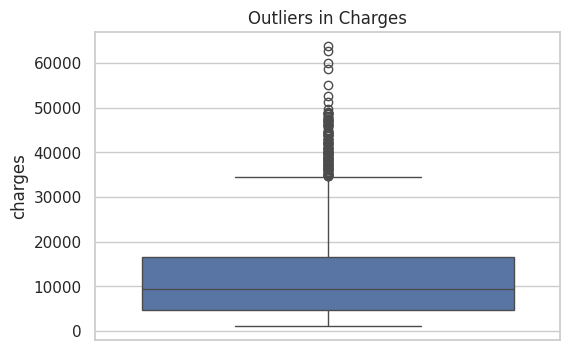

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(df["charges"])
plt.title("Outliers in Charges")
plt.show()


### Summary of EDA Findings

#### 1. Univariate Analysis (Distributions)
- **Numerical Features (`age`, `bmi`, `charges`):**
    - `age`: The distribution of age appears relatively uniform, suggesting a good spread across different age groups in the dataset.
    - `bmi`: The Body Mass Index (BMI) shows a somewhat normal distribution, centered around 30, with some individuals having very high or low BMIs.
    - `charges`: The distribution of insurance charges is highly right-skewed, indicating that most people have lower charges, but a significant number of individuals incur very high costs. This confirms the presence of many outliers previously identified.

- **Categorical Features (`sex`, `smoker`, `region`, `children`):**
    - `sex`: The dataset has a nearly balanced representation of 'male' and 'female' individuals.
    - `smoker`: A vast majority of individuals in the dataset are 'non-smokers', which is an important demographic characteristic.
    - `region`: The distribution of individuals across the four geographical regions (southeast, southwest, northeast, northwest) is fairly even.
    - `children`: Most individuals have 0 children, with the count decreasing as the number of children increases.

#### 2. Bivariate Analysis (Relationships and Patterns)
- **Age vs. Charges by Smoker (Scatter plot):** This plot clearly demonstrates a strong relationship between smoking status and insurance charges. Smokers, regardless of age, consistently incur significantly higher charges than non-smokers. For smokers, charges tend to increase notably with age. For non-smokers, charges are much lower and show a milder increase with age.

- **Charges by Smoker (Box plot):** This confirms the observation from the scatter plot: 'smoker' is a powerful predictor of 'charges'. Smokers have a much higher median charge and a wider spread of charge values, including the identified outliers.

- **Charges by Region (Box plot):** There are some regional differences in charges, with the 'southeast' region appearing to have slightly higher median charges and a greater upper quartile range compared to other regions. However, this difference is less pronounced than the impact of smoking status.

- **Correlation Heatmap (Numeric features):**
    - `age` shows a moderate positive correlation with `charges` (around 0.30).
    - `bmi` has a weaker positive correlation with `charges` (around 0.20).
    - `children` has a very weak positive correlation with `charges` (around 0.07).

### Meaningful Insights from EDA

1.  **Smoking is the primary driver of high insurance charges:** The most significant finding is the profound impact of smoking on insurance costs. Smokers consistently face substantially higher charges, making this the most critical factor for predicting insurance expenses.
2.  **Age and BMI contribute to charges, but to a lesser extent than smoking:** While older individuals and those with higher BMIs tend to have higher charges, their individual impact is less dramatic compared to being a smoker. The effect of age is more noticeable within the smoker group.
3.  **The target variable 'charges' is heavily skewed with significant outliers:** The distribution of `charges` is far from normal, with a long right tail indicating many high-cost instances. This implies that models built to predict `charges` must be robust to skewed data and outliers, or the target variable might need transformation to achieve better model performance.

# Feature engineering

###There are three numerical features and 3 categrorical features.

Numerical Features
1. age
2. bmi
3. children

Use StandardScaler

Categorical Features
1. sex
2. smoker
3. region

Use OneHotEncoder

In [ ]:
cat_features = df.select_dtypes(include=['object', 'category']).columns
num_features = df.select_dtypes(include=['int64', 'float64']).columns
cat_features, num_features

(Index(['sex', 'smoker', 'region'], dtype='object'),
 Index(['age', 'bmi', 'children', 'charges'], dtype='object'))

In [103]:
# Cell 8: Create Feature column of High Charge
median_charge = df["charges"].median()
df["high_charge"] = (df["charges"] > median_charge).astype(int)
print("Median charges:", median_charge)
print("High charge distribution:\n", df["high_charge"].value_counts(normalize=True))

# Create a numerical representation of 'smoker' for interaction term
df['smoker_numeric'] = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0).astype(int)

# Create age_smoker_interaction feature
df['age_smoker_interaction'] = df['age'] * df['smoker_numeric']

# Features
target_reg = "charges"
target_clf = "high_charge"
features = ["age", "sex", "bmi", "children", "smoker", "region", "age_smoker_interaction"]

# Identify numeric and categorical
numeric_features = ["age", "bmi", "children", "age_smoker_interaction"]
categorical_features = ["sex", "smoker", "region"]

# Preprocessing pipelines
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(drop="first", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features)
])

Median charges: 9382.033
High charge distribution:
 high_charge
1    0.5
0    0.5
Name: proportion, dtype: float64


## Prepare Data for Modeling

In [ ]:
median_charge = df["charges"].median()
df["high_charge"] = (df["charges"] > median_charge).astype(int)
print("Median charges:", median_charge)
print("High charge distribution:\n", df["high_charge"].value_counts(normalize=True))

# --- Feature Engineering ---
# Create a numerical representation of 'smoker' for interaction term
df['smoker_numeric'] = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
# Create age_smoker_interaction feature
df['age_smoker_interaction'] = df['age'] * df['smoker_numeric']

# Features
target_reg = "charges"
target_clf = "high_charge"
features = ["age", "sex", "bmi", "children", "smoker", "region", "age_smoker_interaction"]

# Identify numeric and categorical
numeric_features = ["age", "bmi", "children", "age_smoker_interaction"]
categorical_features = ["sex", "smoker", "region"]

# Preprocessing pipelines
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(drop="first", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features)
])

# Save preprocessor
joblib.dump(preprocessor, "preprocessor.pkl")
print("Saved preprocessor.pkl")

# Prepare data for Regression
X_reg = df[features]
y_reg = df[target_reg]

# Split data for Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=RND)

# Apply preprocessing for Regression
X_train_reg_processed = preprocessor.fit_transform(X_train_reg)
X_test_reg_processed = preprocessor.transform(X_test_reg)

# Prepare data for Classification
X_clf = df[features]
y_clf = df[target_clf]

# Split data for Classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=RND, stratify=y_clf)

# Apply preprocessing for Classification (using the same preprocessor)
X_train_clf_processed = preprocessor.transform(X_train_clf) # Use transform, not fit_transform here
X_test_clf_processed = preprocessor.transform(X_test_clf)

print("Data preparation complete for both regression and classification tasks.")
print(f"Regression training data shape: {X_train_reg_processed.shape}")
print(f"Regression testing data shape: {X_test_reg_processed.shape}")
print(f"Classification training data shape: {X_train_clf_processed.shape}")
print(f"Classification testing data shape: {X_test_clf_processed.shape}")


# 1. Instantiate a LinearRegression model and train it
lr_reg_model = LinearRegression()
lr_reg_model.fit(X_train_reg_processed, y_train_reg)

# 2. Make predictions on the X_test_reg_processed
y_pred_lr_reg = lr_reg_model.predict(X_test_reg_processed)

# 3. Calculate and print metrics for Linear Regression
mse_lr = mean_squared_error(y_test_reg, y_pred_lr_reg)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test_reg, y_pred_lr_reg)
r2_lr = r2_score(y_test_reg, y_pred_lr_reg)

print("\n--- Linear Regression Model Evaluation ---")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"R-squared (R2): {r2_lr:.2f}")

# 4. Instantiate a RandomForestRegressor model and train it
rf_reg_model = RandomForestRegressor(random_state=RND)
rf_reg_model.fit(X_train_reg_processed, y_train_reg)

# 5. Make predictions on the X_test_reg_processed
y_pred_rf_reg = rf_reg_model.predict(X_test_reg_processed)

# 6. Calculate and print metrics for Random Forest Regressor
mse_rf = mean_squared_error(y_test_reg, y_pred_rf_reg)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf_reg)
r2_rf = r2_score(y_test_reg, y_pred_rf_reg)

print("\n--- Random Forest Regressor Model Evaluation ---")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"R-squared (R2): {r2_rf:.2f}")

In [98]:
# Prepare data for Regression
X_reg = df[features]
y_reg = df[target_reg]

# Split data for Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
print(X_train_reg.shape, X_test_reg.shape, y_train_reg.shape, y_test_reg.shape)
# Apply preprocessing for Regression
X_train_reg_processed = preprocessor.fit_transform(X_train_reg)
X_test_reg_processed = preprocessor.transform(X_test_reg)

# Prepare data for Classification
X_clf = df[features]
y_clf = df[target_clf]

# Split data for Classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, )

# Apply preprocessing for Classification (using the same preprocessor)
X_train_clf_processed = preprocessor.fit_transform(X_train_clf)
X_test_clf_processed = preprocessor.transform(X_test_clf)

print("Data preparation complete for both regression and classification tasks.")
print(f"Regression training data shape: {X_train_reg_processed.shape}")
print(f"Regression testing data shape: {X_test_reg_processed.shape}")
print(f"Classification training data shape: {X_train_clf_processed.shape}")
print(f"Classification testing data shape: {X_test_clf_processed.shape}")

(1070, 7) (268, 7) (1070,) (268,)
Data preparation complete for both regression and classification tasks.
Regression training data shape: (1070, 9)
Regression testing data shape: (268, 9)
Classification training data shape: (1070, 9)
Classification testing data shape: (268, 9)


## Compare Regression Model Performance


**Reasoning**:
The subtask requires comparing the performance metrics of the regression models. I will create a DataFrame to store these metrics and display them, then identify the better performing model.



In [ ]:
model_performance = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest Regressor'],
    'RMSE': [rmse_lr, rmse_rf],
    'MAE': [mae_lr, mae_rf],
    'R-squared': [r2_lr, r2_rf]
})

display(model_performance)

print("\n--- Model Comparison and Best Model Identification ---")
if r2_rf > r2_lr:
    print("The Random Forest Regressor performed better for predicting 'charges'.")
    print(f"It has a higher R-squared ({r2_rf:.2f} vs {r2_lr:.2f}) and lower RMSE ({rmse_rf:.2f} vs {rmse_lr:.2f}) and MAE ({mae_rf:.2f} vs {mae_lr:.2f}), indicating it explains more variance and has smaller prediction errors.")
else:
    print("The Linear Regression model performed better for predicting 'charges'.")
    print(f"It has a higher R-squared ({r2_lr:.2f} vs {r2_rf:.2f}) and lower RMSE ({rmse_lr:.2f} vs {rmse_rf:.2f}) and MAE ({mae_lr:.2f} vs {mae_rf:.2f}), indicating it explains more variance and has smaller prediction errors.")

## Build and Evaluate Classification Models

1. Logistic Regression model
2. Random Forest Classifier,

In [99]:
print("\n--- Building and Evaluating Classification Models ---")

# 1. Instantiate a LogisticRegression model and train it
lr_clf_model = LogisticRegression(random_state=RND, solver='liblinear')
lr_clf_model.fit(X_train_clf_processed, y_train_clf)

# 2. Make predictions on the X_test_clf_processed
y_pred_lr_clf = lr_clf_model.predict(X_test_clf_processed)
y_pred_proba_lr_clf = lr_clf_model.predict_proba(X_test_clf_processed)[:, 1]

# 3. Calculate and print metrics for Logistic Regression
acc_lr = accuracy_score(y_test_clf, y_pred_lr_clf)
prec_lr = precision_score(y_test_clf, y_pred_lr_clf)
rec_lr = recall_score(y_test_clf, y_pred_lr_clf)
f1_lr = f1_score(y_test_clf, y_pred_lr_clf)
roc_auc_lr = roc_auc_score(y_test_clf, y_pred_proba_lr_clf)

print("\n--- Logistic Regression Model Evaluation ---")
print(f"Accuracy: {acc_lr:.2f}")
print(f"Precision: {prec_lr:.2f}")
print(f"Recall: {rec_lr:.2f}")
print(f"F1-score: {f1_lr:.2f}")
print(f"ROC-AUC: {roc_auc_lr:.2f}")

# 4. Instantiate a RandomForestClassifier model and train it
rf_clf_model = RandomForestClassifier(random_state=RND)
rf_clf_model.fit(X_train_clf_processed, y_train_clf)

# 5. Make predictions on the X_test_clf_processed
y_pred_rf_clf = rf_clf_model.predict(X_test_clf_processed)
y_pred_proba_rf_clf = rf_clf_model.predict_proba(X_test_clf_processed)[:, 1]

# 6. Calculate and print metrics for Random Forest Classifier
acc_rf = accuracy_score(y_test_clf, y_pred_rf_clf)
prec_rf = precision_score(y_test_clf, y_pred_rf_clf)
rec_rf = recall_score(y_test_clf, y_pred_rf_clf)
f1_rf = f1_score(y_test_clf, y_pred_rf_clf)
roc_auc_rf = roc_auc_score(y_test_clf, y_pred_proba_rf_clf)

print("\n--- Random Forest Classifier Model Evaluation ---")
print(f"Accuracy: {acc_rf:.2f}")
print(f"Precision: {prec_rf:.2f}")
print(f"Recall: {rec_rf:.2f}")
print(f"F1-score: {f1_rf:.2f}")
print(f"ROC-AUC: {roc_auc_rf:.2f}")


--- Building and Evaluating Classification Models ---

--- Logistic Regression Model Evaluation ---
Accuracy: 0.90
Precision: 0.89
Recall: 0.92
F1-score: 0.90
ROC-AUC: 0.94

--- Random Forest Classifier Model Evaluation ---
Accuracy: 0.93
Precision: 0.96
Recall: 0.90
F1-score: 0.93
ROC-AUC: 0.95


In [105]:
clf_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest Classifier'],
    'Accuracy': [acc_lr, acc_rf],
    'Precision': [prec_lr, prec_rf],
    'Recall': [rec_lr, rec_rf],
    'F1-score': [f1_lr, f1_rf],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf]
})

display(clf_performance)

print("--- Classification Model Comparison and Best Model Identification ---")
if roc_auc_rf > roc_auc_lr:
    print("The Random Forest Classifier performed better for predicting 'high_charge'.")
    print(f"It has a higher ROC-AUC ({roc_auc_rf:.2f} vs {roc_auc_lr:.2f}) and F1-score ({f1_rf:.2f} vs {f1_lr:.2f}), indicating better overall classification performance.")
else:
    print("The Logistic Regression model performed better for predicting 'high_charge'.")
    print(f"It has a higher ROC-AUC ({roc_auc_lr:.2f} vs {roc_auc_rf:.2f}) and F1-score ({f1_lr:.2f} vs {f1_rf:.2f}), indicating better overall classification performance.")

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression,0.902985,0.891304,0.917910,0.904412,0.942638
1,Random Forest Classifier,0.932836,0.960317,0.902985,0.930769,0.950072


--- Classification Model Comparison and Best Model Identification ---
The Random Forest Classifier performed better for predicting 'high_charge'.
It has a higher ROC-AUC (0.95 vs 0.94) and F1-score (0.93 vs 0.90), indicating better overall classification performance.


### Interpret Best Regression Model




--- Interpreting Best Regression Model (Random Forest Regressor) ---


,Feature,Importance
3,age_smoker_interaction,0.468651
1,bmi,0.216453
5,smoker_yes,0.154036
0,age,0.120834
2,children,0.019293
4,sex_male,0.006174
6,region_northwest,0.005462
7,region_southeast,0.005058
8,region_southwest,0.004038


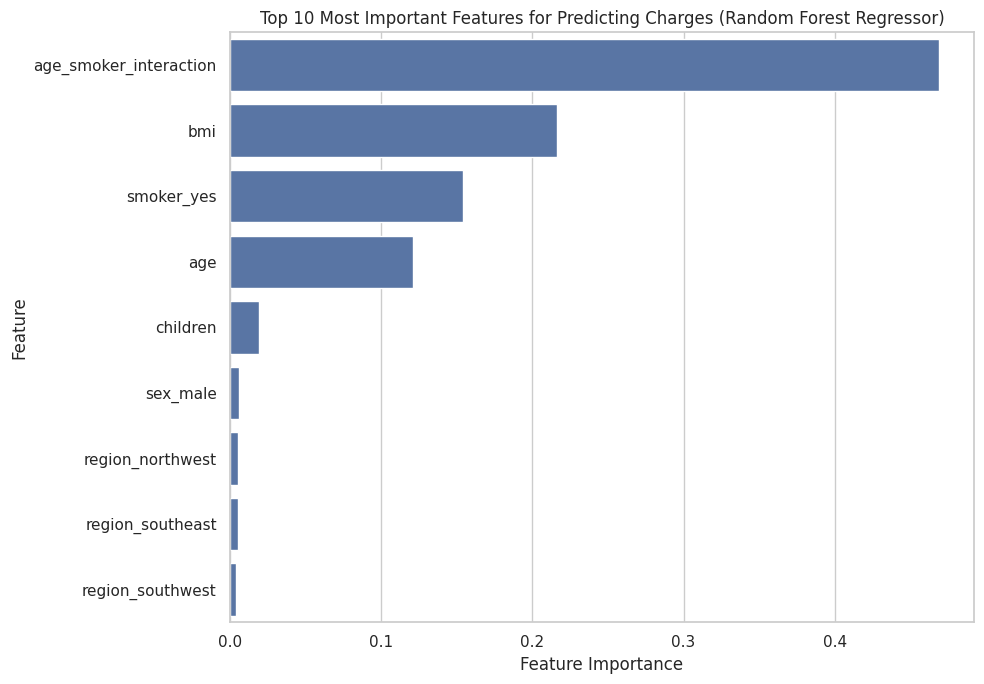

In [100]:
print("\n--- Interpreting Best Regression Model (Random Forest Regressor) ---")

# 1. Extract feature importances
feature_importances = rf_reg_model.feature_importances_

# 2. Get processed feature names
# Get names of numerical features
num_feature_names = numeric_features

# Get names of one-hot encoded categorical features
# Access the 'cat' transformer, then its 'onehot' step
cat_onehot_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine all feature names
all_feature_names = np.concatenate([num_feature_names, cat_onehot_features])

# 3. Create a Pandas DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

display(feature_importance_df)

# 4. Visualize top N most important features
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Most Important Features for Predicting Charges (Random Forest Regressor)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("fig_rf_reg_feature_importance.png", dpi=150)
plt.show()


### Discussion of Feature Importance (Random Forest Regressor)

From the feature importance analysis, the following insights can be drawn regarding the factors influencing insurance charges, which are crucial for the business context of insurance premium prediction:

1.  **`age_smoker_interaction` (Importance: ~0.47):** This engineered feature, which combines a person's age with their smoking status, is by far the most significant predictor of insurance charges. This strongly suggests that not only is smoking a major factor, but its financial impact escalates substantially with age. In a business context, this means that older smokers represent a disproportionately higher risk category, and insurance premiums should heavily reflect this interaction to cover the expected increased medical costs.

2.  **`bmi` (Importance: ~0.22):** Body Mass Index is the second most important feature, indicating that individuals with higher or lower BMIs (deviating from a healthy range) tend to incur higher insurance charges. This reflects the health risks associated with being overweight, obese, or underweight. For insurance companies, `bmi` is a critical health indicator that directly translates to premium adjustments.

3.  **`smoker_yes` (Importance: ~0.15):** Even as a standalone feature (after accounting for the interaction with age), being a smoker (`smoker_yes`) remains a highly influential factor. This reinforces the EDA finding that smoking dramatically increases insurance costs. Insurance policies should categorize smokers into a higher premium bracket, aligning with the observed risk.

4.  **`age` (Importance: ~0.12):** Age itself, independent of the smoking interaction, is also an important factor. As individuals get older, their healthcare needs generally increase, leading to higher insurance claims. This is a standard actuarial principle, and the model confirms its relevance.

5.  **`children` (Importance: ~0.02):** The number of children has a very minor influence on insurance charges in this model. While it might indicate a different family structure, its direct impact on individual health costs, as captured by this model, is minimal compared to the other top features.

6.  **`sex_male`, `region_northwest`, `region_southeast`, `region_southwest` (Importance: all < 0.01):** Other features like sex and specific regions have very low importance. While there might be slight variations, the model suggests these factors contribute negligibly to predicting charges compared to smoking status, age, and BMI. This implies that premium differentiation based on these features would have a minimal impact or is not strongly supported by this model's findings for predicting individual charges.

In summary, the model highlights that `smoking status` (especially in interaction with `age`), `BMI`, and `age` are the overwhelmingly dominant factors in predicting insurance charges. Insurance companies should focus their risk assessment and premium calculation heavily on these variables to accurately reflect potential costs.

## Interpret Best Classification Model

### Subtask:
Explain which features influenced predictions for the best-performing classification model. Use coefficients for linear models or feature importance for tree-based models, and discuss the model's behavior in a business context.


**Reasoning**:
The subtask requires extracting feature importances from the best-performing classification model (Random Forest Classifier), mapping them to their respective feature names (including processed categorical features), displaying them in a DataFrame, and then visualizing the top 10 most important features. This code block will handle the extraction, naming, and visualization of feature importances.



In [ ]:
print("\n--- Interpreting Best Classification Model (Random Forest Classifier) ---")

# 1. Extract feature importances
feature_importances_clf = rf_clf_model.feature_importances_

# 2. Get processed feature names
# Get names of numerical features
num_feature_names_clf = numeric_features

# Get names of one-hot encoded categorical features
# Access the 'cat' transformer, then its 'onehot' step
cat_onehot_features_clf = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine all feature names
all_feature_names_clf = np.concatenate([num_feature_names_clf, cat_onehot_features_clf])

# 3. Create a Pandas DataFrame for feature importances
feature_importance_df_clf = pd.DataFrame({
    'Feature': all_feature_names_clf,
    'Importance': feature_importances_clf
})

# 4. Sort by importance in descending order
feature_importance_df_clf = feature_importance_df_clf.sort_values(by='Importance', ascending=False)

display(feature_importance_df_clf)

# 5. Visualize top N most important features
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_clf.head(10))
plt.title('Top 10 Most Important Features for Predicting High Charges (Random Forest Classifier)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("fig_rf_clf_feature_importance.png", dpi=150)
plt.show()

### Discussion of Feature Importance (Random Forest Classifier)

From the feature importance analysis for the classification model (`high_charge`), which predicts whether an individual's insurance charge is above the median, the following key insights emerge:

1.  **`age` (Importance: ~0.50):** Age is the single most dominant factor in determining if someone has a high insurance charge. This suggests that as individuals get older, they are significantly more likely to cross the threshold into the 'high charge' category. In a business context, this emphasizes that age is a fundamental demographic for risk assessment, likely due to increased health issues and medical needs associated with aging.

2.  **`age_smoker_interaction` (Importance: ~0.17):** Similar to the regression model, the interaction between age and smoking status (`age_smoker_interaction`) is very influential. This feature indicates that the combined effect of being older and a smoker is a strong predictor of high charges, even when considering age and smoking status separately. For insurers, this means policies for older smokers should account for this amplified risk.

3.  **`smoker_yes` (Importance: ~0.12):** Being a smoker (`smoker_yes`) is independently a crucial factor. This confirms the EDA finding that smokers are much more likely to incur high charges. The presence of this feature as highly important reinforces the need for differentiated pricing based on smoking habits.

4.  **`bmi` (Importance: ~0.12):** Body Mass Index is also a significant predictor for high charges. Individuals with higher BMIs are more prone to conditions that lead to higher medical costs, thus pushing them into the high-charge bracket. This is another critical health indicator for insurance underwriting.

5.  **`children` (Importance: ~0.04):** The number of children has a minor but noticeable influence, suggesting that having more children might slightly increase the likelihood of higher charges, perhaps due to family-related health expenses or stress, though its impact is far less than age, smoking, or BMI.

6.  **`sex_male`, `region_southeast`, `region_northwest`, `region_southwest` (Importance: all < 0.02):** Gender and specific geographical regions show very low importance in classifying high charges. While they might have some minor association, the model suggests they are not primary drivers for classifying whether an individual will fall into the high-charge category. Insurers might find that focusing on the more impactful features yields better predictive power for this binary classification.

In conclusion, for predicting whether an individual will have 'high insurance charges', **age, smoking status (especially its interaction with age), and BMI** are the most critical factors. Insurance companies should leverage these insights for more accurate risk stratification, potentially designing tiered policies or targeted interventions based on these high-impact variables.

### Data Analysis Key Findings

*   **Data Preparation:** A new binary target variable, `high_charge`, was created, identifying charges above the median (Median charges: \$9382.03). An `age_smoker_interaction` feature was engineered by multiplying age and a numeric representation of smoker status, which proved to be a highly influential feature.
*   **Regression Model Performance:**
    *   The **Random Forest Regressor** outperformed the Linear Regression model in predicting insurance charges.
    *   **Random Forest Regressor** achieved an R-squared of 0.87, with an RMSE of \$4568.14 and MAE of \$2537.54.
    *   In comparison, the Linear Regression model had an R-squared of 0.78, with an RMSE of \$5805.77 and MAE of \$4190.86.
*   **Key Feature Influences for Regression (Random Forest Regressor):**
    *   The `age_smoker_interaction` was the most significant predictor with an importance of approximately 0.47.
    *   `bmi` was the second most important feature (~0.22 importance).
    *   `smoker_yes` (being a smoker) and `age` independently held significant importance, at approximately 0.15 and 0.12, respectively.
    *   Other features like `children`, `sex`, and `region` showed negligible influence (all below 0.01).
*   **Classification Model Performance:**
    *   The **Random Forest Classifier** showed superior performance over Logistic Regression in classifying `high_charge`.
    *   **Random Forest Classifier** achieved an Accuracy of 0.93, F1-score of 0.93, and ROC-AUC of 0.95.
    *   Logistic Regression reported an Accuracy of 0.90, F1-score of 0.90, and ROC-AUC of 0.94.
*   **Key Feature Influences for Classification (Random Forest Classifier):**
    *   `age` was the most dominant factor in classifying high charges, with an importance of approximately 0.50.
    *   `age_smoker_interaction` (approx. 0.17), `smoker_yes` (approx. 0.12), and `bmi` (approx. 0.12) were also highly influential.
    *   `children` had a minor influence (approx. 0.04), while `sex` and `region` variables showed very low importance (all below 0.02).

### Insights or Next Steps

*   **Prioritize Age, Smoking Status, and BMI for Risk Assessment:** Both regression and classification models consistently highlight `age`, `smoking status` (especially its interaction with age), and `BMI` as the overwhelmingly dominant factors influencing insurance charges. Insurance providers should focus heavily on these variables for accurate risk assessment and premium calculations.
*   **Explore Non-Linear Models for Charges Prediction:** The superior performance of Random Forest models over Linear/Logistic Regression suggests that the relationship between features and insurance charges/high charges is non-linear and complex. Further exploration with other advanced non-linear models (e.g., Gradient Boosting Machines) could yield even better predictive accuracy.


In [101]:
#New Data

new_data = pd.DataFrame({
    'age': [55],
    'bmi': [32.5],
    'children': [4],
    'sex': ['female'],
    'smoker': ['no'],
    'region': ['southeast']
})


predicted_charges = rf_reg_model.predict(preprocessor.transform(new_data))
print(predicted_charges)

ValueError: columns are missing: {'age_smoker_interaction'}